In [30]:
import requests
from shapely.geometry import Point, Polygon, MultiPolygon
from datetime import datetime
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import shapely
import os
import sqlite3 as sl
import itertools
from tqdm.notebook import tqdm
tqdm.pandas()

import logging
logging.getLogger().setLevel(logging.INFO)

from dotenv import load_dotenv
load_dotenv()

from bing_helper import Bing

DROOT = '../1-data/'
os.makedirs(os.path.join(DROOT, '3-interim', 'populationmasks'), exist_ok=True)

In [19]:
cities = pd.read_excel(os.path.join(DROOT, '1-research', 'cities.xlsx'), index_col=0)
cities.head(10)

,City,ctr_name,ctr_lat,ctr_lon,cells,Country,ID_HDC_G0
0,Vienna,Rathaus Wien,48.21080,16.35784,4381,AUT,3027
1,Graz,Hauptplatz Graz,47.06955,15.43383,1168,AUT,3000
2,Brussels,Brussels Town hall,50.84642,4.35232,3747,BEL,2135
3,Berlin,Old City Hall,52.51687,13.41160,5187,DEU,2851
4,Hamburg,Rathaus,53.55035,9.99232,4912,DEU,2531
5,Copenhagen,Kobenhavns Radhus,55.67537,12.56936,3090,DNK,2749
6,Aarhus,Aarhus Radhus,56.15280,10.20021,1151,DNK,2518
7,Madrid,Ajuntamiento de Madrid,40.41831,-3.69260,4949,ESP,1701
8,Barcelona,Ajuntament de Barcelona,41.38228,2.17532,2540,ESP,2051
9,Paris,Hôtel de Ville,48.85595,2.35167,5178,FRA,2046


In [20]:
KEY = os.environ['BING_API_KEY']
CACHE = os.path.join(DROOT, '3-interim', 'bing_cache.db')
client = Bing(KEY, CACHE)

In [21]:
cities = cities.iloc[8:9]
for i, city in cities.iterrows():
    print(city.City)
    file = f'{city.ID_HDC_G0}.pcl'
    df = pd.read_pickle(os.path.join(DROOT, '3-interim', 'populationmasks', file))
    gdf = gpd.GeoDataFrame(df)
    
    origins  = enumerate(gdf.centroid.to_crs("EPSG:4326"))
    times    = range(5, 55, 10)
    modes_dt = [('driving', 'driving-peak', datetime(2023, 5, 2, 8, 30, 37)), 
                ('driving', 'driving',      datetime(2023, 5, 2, 13, 0, 37)), 
#                 ('transit', 'transit-peak', datetime(2023, 5, 2, 8, 30, 37)),
#                 ('transit', 'transit',      datetime(2023, 5, 2, 13, 0, 37)), 
#                 ('walking', 'walking',      datetime(2023, 5, 2, 8, 30, 37))
               ]
    
    batch      = list(itertools.product(origins, times, modes_dt))
    isochrones = client.get_isochrones_async(city.ID_HDC_G0, batch, buf_m=150)
    break;


Barcelona


INFO:root:Out of total 5830, 100.00% cached.


In [86]:
f1 = isochrones[(isochrones.tt_mnts == 15) & (f1['modetime'] == 'driving')]
f1.sample(10)

,uid,pid,startpt,tt_mnts,mode,modetime,dep_dt,geometry
3373,2051-337-driving-15m-v0,337,POINT (2.1300389657074286 41.42005059822283),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((2.01224 41.39721, 2.01222 41.39734, ..."
5633,2051-563-driving-15m-v0,563,POINT (2.079599746071858 41.284831111711036),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((2.05806 41.30568, 2.05806 41.30571, ..."
4013,2051-401-driving-15m-v0,401,POINT (2.0935120712333304 41.38398180114006),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((1.93319 41.47826, 1.93314 41.47838, ..."
5033,2051-503-driving-15m-v0,503,POINT (2.0207118263474624 41.3208793838987),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((1.87864 41.24855, 1.87851 41.24864, ..."
3053,2051-305-driving-15m-v0,305,POINT (2.2141478893292827 41.4471071084045),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((2.07806 41.54086, 2.07802 41.54099, ..."
4293,2051-429-driving-15m-v0,429,POINT (2.033514752469989 41.365950206221655),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((1.89670 41.51103, 1.89665 41.51116, ..."
5143,2051-514-driving-15m-v0,514,POINT (2.1518494669953805 41.3208793838987),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((2.01972 41.38348, 2.01969 41.38361, ..."
53,2051-5-driving-15m-v0,5,POINT (2.3017206568542097 41.62759184489527),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((2.30297 41.62919, 2.30313 41.62914, ..."
2563,2051-256-driving-15m-v0,256,POINT (2.2027874495143838 41.47416783493961),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((2.12557 41.50469, 2.12547 41.50480, ..."
3703,2051-370-driving-15m-v0,370,POINT (2.153530445861246 41.40201526463035),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((2.07466 41.43292, 2.07456 41.43303, ..."


In [87]:
# peak = f1[f1['modetime'] == 'driving-peak']
# offp = f1[f1['modetime'] == 'driving']

# fig, axs = plt.subplots(ncols=2, figsize=(10,5))
# peak.plot(ax=axs[0], color='red', alpha=0.5)
# offp.plot(ax=axs[1], color='blue', alpha=0.5)

# ctx.add_basemap(ax=axs[0], crs=isochrones.crs)
# ctx.add_basemap(ax=axs[1], crs=isochrones.crs)

In [92]:
f1['reach_drive'] = f1.geometry.apply(lambda isoch: gdf[gdf.intersects(isoch)].cell_pop.sum())
f1.head()

/Users/ivo/opt/anaconda3/envs/DUTTv2/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,uid,pid,startpt,tt_mnts,mode,modetime,dep_dt,geometry,reach_drive
3,2051-0-driving-15m-v0,0,POINT (2.2780065593132397 41.636621028437155),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((2.14098 41.51406, 2.14084 41.51414, ...",242695.503998
13,2051-1-driving-15m-v0,1,POINT (2.2899645989946738 41.636621028437155),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((2.15998 41.52224, 2.15982 41.52231, ...",216028.198105
23,2051-2-driving-15m-v0,2,POINT (2.3019226386761082 41.636621028437155),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((2.21021 41.63382, 2.21012 41.63393, ...",109796.593979
33,2051-3-driving-15m-v0,3,POINT (2.277806676003776 41.62759184489527),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((2.27564 41.62761, 2.27562 41.62774, ...",2984.135498
43,2051-4-driving-15m-v0,4,POINT (2.2897636664289927 41.62759184489527),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((2.15793 41.52207, 2.15785 41.52218, ...",218913.920761


In [99]:
f1 = f1.merge(gdf.reset_index(), left_on='pid', right_on='index', suffixes=('', '_gdf'))

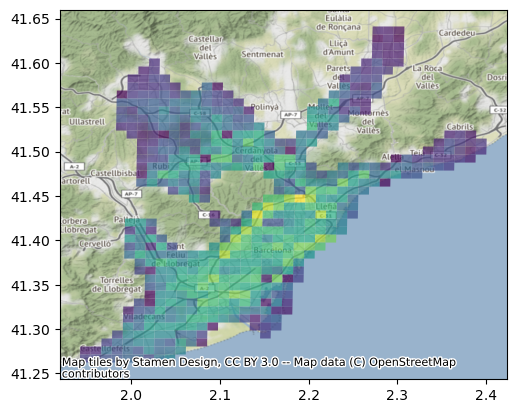

In [100]:
ax = f1.set_geometry('geometry_gdf').plot(column='reach_drive', alpha=0.7)
ctx.add_basemap(ax=ax, crs=f1.crs)

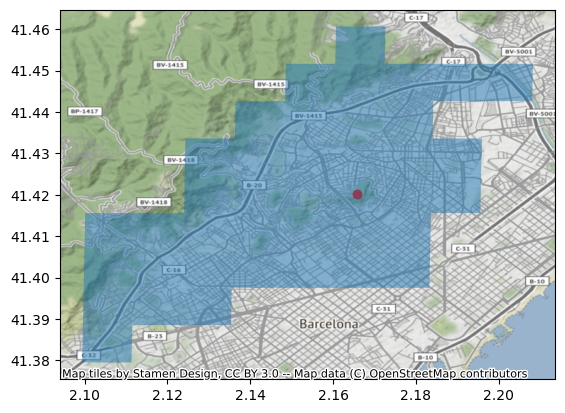

In [81]:
gdf = gdf.to_crs("EPSG:4326")
ax = f1.set_geometry('startpt').iloc[:1].plot(color='red')
gdf[gdf.intersects(f1.iloc[0].geometry)].plot(ax=ax, alpha=0.5)
ctx.add_basemap(ax=ax, crs=gdf.crs)

<Axes: >

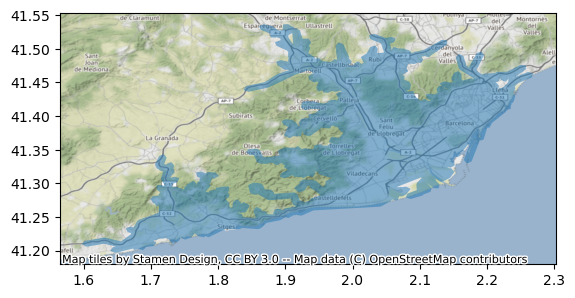

In [18]:
marta_plot = isochrones.sample(1).plot(alpha=0.5)
ctx.add_basemap(ax=marta_plot, crs=isochrones.crs)
marta_plot

In [33]:
# isochrones.merge(gdf)
city_raster = gdf.reset_index()
city_raster = city_raster.rename(columns={'index': 'pid'})


isochrones = isochrones.to_crs(gdf.crs)
city_raster = city_raster.merge(isochrones, how='cross', suffixes=('_rast', '_iso'))
# city_raster['pop'] = city_raster.apply(
#     lambda x: gdf[gdf.overlaps(x['geometry_iso'])].sum('cell_pop'), axis=1)
city_raster.iloc[:5]

,pid_rast,cell_pop,geometry_rast,uid,pid_iso,startpt,tt_mnts,mode,modetime,dep_dt,geometry_iso
0,0,1724.994263,"POLYGON ((1267000.000 5696000.000, 1267000.000...",3027-0-driving-peak-5m-v0,0,POINT (16.309324204775518 48.311300837221545),5,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((1264063.573 5697283.282, 1264062.257..."
1,0,1724.994263,"POLYGON ((1267000.000 5696000.000, 1267000.000...",3027-0-driving-5m-v0,0,POINT (16.309324204775518 48.311300837221545),5,driving,driving,2023-05-02 13:00:37,"POLYGON ((1264063.573 5697283.282, 1264062.257..."
2,0,1724.994263,"POLYGON ((1267000.000 5696000.000, 1267000.000...",3027-0-driving-peak-15m-v0,0,POINT (16.309324204775518 48.311300837221545),15,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((1257813.540 5696851.300, 1257810.519..."
3,0,1724.994263,"POLYGON ((1267000.000 5696000.000, 1267000.000...",3027-0-driving-15m-v0,0,POINT (16.309324204775518 48.311300837221545),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((1257813.540 5696851.300, 1257810.519..."
4,0,1724.994263,"POLYGON ((1267000.000 5696000.000, 1267000.000...",3027-0-driving-peak-25m-v0,0,POINT (16.309324204775518 48.311300837221545),25,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((1248076.012 5695924.695, 1248072.177..."


In [34]:
city_raster.iloc[:5].apply(
    lambda x: gdf[gdf.overlaps(x['geometry_iso'])], axis=1)

0          cell_pop                                ...
1          cell_pop                                ...
2            cell_pop                              ...
3            cell_pop                              ...
4            cell_pop                              ...
dtype: object

<Axes: >

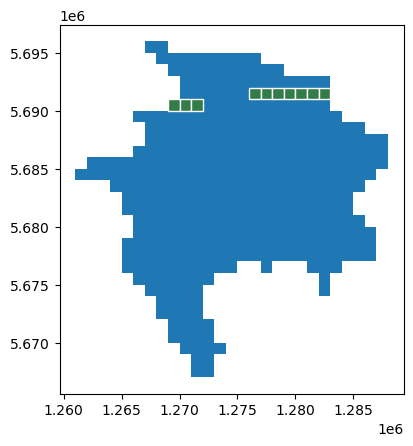

In [6]:
ax = gdf.plot()
gdf.iloc[40:50].plot(edgecolor=u'white', color=np.random.rand(3,), ax=ax)

In [7]:
fig, axs = plt.subplots(ncols=5, figsize=(20, 4))
for i, t in enumerate(range(5, 55, 10)):
    stockholm = client.get_isochrone(STADSHUSET, f'stockholm-{t}', t, STARTDATE, 'driving')
    stockholm.plot(ax=axs[i])
    ctx.add_basemap(axs[i], crs="EPSG:4326")

NameError: name 'plt' is not defined